# Which European Football League is the best (according to data)? 

In this project I analyze the Football Database that can be downloaded at the following [link](https://www.kaggle.com/datasets/davidcariboo/player-scores). This database that contains information about football games, players, games events, and competitions during the period 2012-2022, can be used to reveal meaningful insights about the main football leagues in Europe. 

Football is the most popular sport in the world with an estimated of 250 million active players according to [Wikipedia](https://en.wikipedia.org/wiki/Association_football). Furthermore, millions of tv spectators watch football matches of their favorite club playing both domestic and international competitions. Each competition, club, and player provide an incredible amount of data that can be processed and analyzed to reveal hidden patterns. 

To analyze the information in this database I will use mainly PySpark and SQL and also some other libraries to build some visualizations. PySpark is the Python API for Apache Spark and is a powerful tool for working with Big Data. Although this database is not large enough or complex to be considered as Big Data, it provides a good starting point for learning PySpark and SQL. 

In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# To start using PySpark we need to create a new session, this automatically creates a new SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("FootballApp").getOrCreate()

23/06/26 07:46:06 WARN Utils: Your hostname, betor94-Satellite-L845D resolves to a loopback address: 127.0.1.1; using 192.168.0.2 instead (on interface wlp2s0)
23/06/26 07:46:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/26 07:46:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
print("Spark Session:")
spark

Spark Session:


In [4]:
# This is the folder containing the data
files_path = os.path.join(os.getcwd(), 'files')
files_path

'/home/betor94/Documents/Projects/Football Project/files'

In [5]:
# List all files in folder
print(*os.listdir(files_path), sep='\n')

competitions.csv
clubs.csv
club_games.csv
games.csv
player_valuations.csv
appearances.csv
players.csv
game_events.csv


In [6]:
# Store the name files into a list
names = list(map(lambda x: x.split('.')[0], os.listdir(files_path)))
names

['competitions',
 'clubs',
 'club_games',
 'games',
 'player_valuations',
 'appearances',
 'players',
 'game_events']

## Loading data 

In [7]:
# We use spark .csv method to read data into dataframes. 
# The information is not loaded in memory until an action is executed
competitions = spark.read.csv('files/competitions.csv', header=True, inferSchema=True)
clubs = spark.read.csv('files/clubs.csv', header=True, inferSchema=True)
club_games = spark.read.csv('files/club_games.csv', header=True, inferSchema=True)
games = spark.read.csv('files/games.csv', header=True, inferSchema=True)
player_valuations = spark.read.csv('files/player_valuations.csv', header=True, inferSchema=True)
appearances = spark.read.csv('files/appearances.csv', header=True, inferSchema=True)
players = spark.read.csv('files/players.csv', header=True, inferSchema=True)
game_events = spark.read.csv('files/game_events.csv', header=True, inferSchema=True)

In [8]:
# Store dataframes into a list
dataframes = [competitions, clubs, club_games, games,
              player_valuations, appearances, players, game_events]

In [9]:
# We can use the printSchema method to find datatypes
print(competitions.printSchema())

root
 |-- competition_id: string (nullable = true)
 |-- competition_code: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sub_type: string (nullable = true)
 |-- type: string (nullable = true)
 |-- country_id: integer (nullable = true)
 |-- country_name: string (nullable = true)
 |-- domestic_league_code: string (nullable = true)
 |-- confederation: string (nullable = true)
 |-- url: string (nullable = true)

None


In [10]:
# To run sql queries we need to create temporary tables 
competitions.createOrReplaceTempView("Competitions")
clubs.createOrReplaceTempView("Clubs")
club_games.createOrReplaceTempView("Club_games")
games.createOrReplaceTempView("Games")
player_valuations.createOrReplaceTempView("Valuations")
appearances.createOrReplaceTempView("Appearances")
players.createOrReplaceTempView("Players")
game_events.createOrReplaceTempView("Events")

In [11]:
# list all tables in the database
spark.catalog.listTables()

[Table(name='Appearances', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Club_games', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Clubs', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Competitions', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Events', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Games', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Players', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Valuations', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

## Problem statement

Before beginning any kind of analysis is important to state what we are trying to achieve in this project; that is, what is the problem to be solved. Since we have information about all football leagues in Europe we can use data, statistics, and visualizations to compare their performance; this way, we can answer the question: Which European Football League is the best?. Of course this question is very general and does not tell us where we should start. Furthermore, this database does not provide information about tv-rights deals, sponsorship deals or audience numbers. For these reasons, we first need to define what does it mean to be the best football league in a purely sporting context and use this to formulate more specific questions that can be answered using this database.

To measure the performance of each football league we can use **metrics** such as:
- total number of goals in a season or the average number of goals per game
- difference in points from first to last which measures how competitive the league is
- the number of different champions over the analyzed period 
- the number of clubs playing the knockout stage of international competitions 
- number of points and victories at international competitions 
- the number of top players playing the domestic tournament (assuming all players are fairly valued according to their skills)

Using these metrics we can start exploring the difference, in terms of performance, between different European football leagues. Note, however, that these metrics are not exhaustive and only measure some elements that reflect the general performance of a country league.

The **first goal** is to generate a dataset that contains all information related to these metrics. Once this dataset is ready, the **second goal** is to build visualizations and compute metrics that allows us to answer the main question. 

## Exploratory Data Analysis

We can start by making an elementary exploration of data such as counting the number of rows and columns in each dataframe, counting the number of missing values, or computing some summary statistics for numeric variables.

In [46]:
for name, df in zip(names, dataframes):
    print("Table: {} has {} rows and {} columns".format(name, df.count(), len(df.columns)))
    print("-------------------")

Table: competitions has 43 rows and 10 columns
-------------------
Table: clubs has 411 rows and 16 columns
-------------------
Table: club_games has 124494 rows and 11 columns
-------------------
Table: games has 62247 rows and 21 columns
-------------------


Table: player_valuations has 424867 rows and 9 columns
-------------------


Table: appearances has 1175579 rows and 13 columns
-------------------


Table: players has 28472 rows and 23 columns
-------------------


Table: game_events has 568252 rows and 7 columns
-------------------


Since the number of columns is large for some dataframes, for the moment I will not count the number of missing values and deal with them when necessary.

### Dataframes columns

In [23]:
def print_columns(name, dataframe):
    print(name.capitalize())
    print('------------------------------')
    print('------------------------------')
    print(*dataframe.columns, sep='\n')
    print('------------------------------')

In [24]:
for name, dt in zip(names, dataframes):
    print_columns(name, dt)

Competitions
------------------------------
------------------------------
competition_id
competition_code
name
sub_type
type
country_id
country_name
domestic_league_code
confederation
url
------------------------------
Clubs
------------------------------
------------------------------
club_id
club_code
name
domestic_competition_id
total_market_value
squad_size
average_age
foreigners_number
foreigners_percentage
national_team_players
stadium_name
stadium_seats
net_transfer_record
coach_name
last_season
url
------------------------------
Club_games
------------------------------
------------------------------
game_id
club_id
own_goals
own_position
own_manager_name
opponent_id
opponent_goals
opponent_position
opponent_manager_name
hosting
is_win
------------------------------
Games
------------------------------
------------------------------
game_id
competition_id
season
round
date
home_club_id
away_club_id
home_club_goals
away_club_goals
home_club_position
away_club_position
home_club

For numerical columns we can compute some summary statistics that provide a general picture of the values we can encounter.

In [70]:
# To explore numerical columns I define a new function
def print_statistical_summary(name, dataframe):
    print(name.capitalize())
    numeric = []
    for var, dt in dataframe.dtypes:
        if dt != "string":
            numeric.append(var)
    dataframe.describe(numeric[0:5]).show()
    if numeric[5:]:
        dataframe.describe(numeric[5:]).show()
    print("----------------------------")

In [71]:
for name, dt in zip(names, dataframes):
    print_statistical_summary(name, dt)

Competitions
+-------+-----------------+
|summary|       country_id|
+-------+-----------------+
|  count|               43|
|   mean|97.09302325581395|
| stddev|69.76689553126808|
|    min|               -1|
|    max|              190|
+-------+-----------------+

----------------------------
Clubs
+-------+------------------+-----------------+------------------+------------------+---------------------+
|summary|           club_id|       squad_size|       average_age| foreigners_number|foreigners_percentage|
+-------+------------------+-----------------+------------------+------------------+---------------------+
|  count|               411|              411|               373|               411|                  365|
|   mean| 4879.778588807786|24.51094890510949|25.691152815013417|10.914841849148418|    44.86410958904111|
| stddev|10896.048964698235| 8.89130854452641|1.4859022134296458| 6.629207263190824|    19.52414395948243|
|    min|                 3|                0|           

+-------+-----------------+------------------+------------------+------------------+------------------+
|summary|          game_id|           club_id|         own_goals|      own_position|       opponent_id|
+-------+-----------------+------------------+------------------+------------------+------------------+
|  count|           124494|            124494|            124494|            124494|            124494|
|   mean|2966066.685302103| 4442.117684386396|1.4473629251208893|6.3571577746718715| 4442.117684386396|
| stddev| 517521.454539547|10212.433373310649|1.3897735782259686| 6.497729526305896|10212.433373310718|
|    min|          2211607|                 1|                 0|                -1|                 1|
|    max|          4080529|            102261|                16|                21|            102261|
+-------+-----------------+------------------+------------------+------------------+------------------+



+-------+------------------+------------------+-------------------+
|summary|    opponent_goals| opponent_position|             is_win|
+-------+------------------+------------------+-------------------+
|  count|            124494|            124494|             124494|
|   mean|1.4473629251208893|6.3571577746718715|0.39197872989862964|
| stddev|1.3897735782259666| 6.497729526305901|0.48819393648610476|
|    min|                 0|                -1|                  0|
|    max|                16|                21|                  1|
+-------+------------------+------------------+-------------------+

----------------------------
Games
+-------+-----------------+-----------------+------------------+-----------------+
|summary|          game_id|           season|      home_club_id|     away_club_id|
+-------+-----------------+-----------------+------------------+-----------------+
|  count|            62247|            62247|             62247|            62247|
|   mean|2966066.685

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|   home_club_goals|   away_club_goals|home_club_position|away_club_position|        attendance|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             62247|             62247|             62247|             62247|             53198|
|   mean| 1.586052339871801|1.3086735103699776|  6.29366877118576| 6.420646778157984|18079.686397984886|
| stddev|1.4194567096379545|1.3452303709834057|6.4611918067823995| 6.533497905238402|17757.992607574455|
|    min|                 0|                 0|                -1|                -1|                 1|
|    max|                15|                16|                21|                21|             99354|
+-------+------------------+------------------+------------------+------------------+------------------+

----------------------------
Player_valuations


+-------+------------------+------------------+
|summary|         player_id|       last_season|
+-------+------------------+------------------+
|  count|            424867|            424867|
|   mean|186950.91933475653|2018.2973377551093|
| stddev|169537.22138299808| 3.304754538067335|
|    min|                10|              2012|
|    max|           1112706|              2022|
+-------+------------------+------------------+



+-------+-------------------+------+-----------------+
|summary|market_value_in_eur|     n|  current_club_id|
+-------+-------------------+------+-----------------+
|  count|             424867|424867|           424867|
|   mean|  2347608.524547682|   1.0|3867.893806767765|
| stddev| 6553862.7228347715|   0.0|9036.474845012157|
|    min|              10000|     1|                3|
|    max|          200000000|     1|            83678|
+-------+-------------------+------+-----------------+

----------------------------
Appearances


+-------+------------------+------------------+------------------+----------------------+
|summary|           game_id|         player_id|    player_club_id|player_current_club_id|
+-------+------------------+------------------+------------------+----------------------+
|  count|           1175579|           1175579|           1175579|               1175579|
|   mean|3113330.1659318516|193612.60503632677|2919.3437582672027|    3420.4750186929164|
| stddev| 453619.3744400348|159958.30881042063| 7114.998287373003|     8767.238174765418|
|    min|           2457642|                10|                 1|                    -1|
|    max|           4080529|           1134218|             83678|                 83678|
+-------+------------------+------------------+------------------+----------------------+



+-------+-------------------+--------------------+-------------------+-------------------+------------------+
|summary|       yellow_cards|           red_cards|              goals|            assists|    minutes_played|
+-------+-------------------+--------------------+-------------------+-------------------+------------------+
|  count|            1175579|             1175579|            1175579|            1175579|           1175579|
|   mean| 0.1487820044420664|0.003641609793982...|0.09641036459480817|0.07338341362001193| 69.64057285814054|
| stddev|0.36715162260886397| 0.06023579964214508| 0.3321103255251135| 0.2813578079529804|29.762996549916483|
|    min|                  0|                   0|                  0|                  0|                 0|
|    max|                  2|                   1|                  6|                  6|               120|
+-------+-------------------+--------------------+-------------------+-------------------+------------------+

---------

+-------+-----------------+------------------+------------------+------------------+------------------+
|summary|          game_id|            minute|           club_id|         player_id|      player_in_id|
+-------+-----------------+------------------+------------------+------------------+------------------+
|  count|           568252|            568252|            568252|            568252|            395629|
|   mean|3024354.375389792|  64.2179121234945| 4293.782621090643|193156.15723481835| 227991.7994282522|
| stddev|532635.3390258882|21.238372501312803|10082.794265506891|172101.48827328222|193932.59735923796|
|    min|          2211607|                 1|                 1|                10|                10|
|    max|          4080529|               120|            102251|           1120127|           1143823|
+-------+-----------------+------------------+------------------+------------------+------------------+

----------------------------


By looking at the previous results there seems to be no outliers or suspicious values. Through this analysis, the most important tables will be Competitions, Games and Club_games since they contain relevant information about all matches and competitions. Now it's time to start answering some questions using data. This can be done in two ways: executing SQL queries directly or programatically through pyspark SQL API. I will use the first option.

Let's start by finding **how many football domestic leagues are present in the database** and the **number of clubs in each league for each season over the whole period (2012-2022)**.

In [63]:
competitions.printSchema()
games.printSchema()

root
 |-- competition_id: string (nullable = true)
 |-- competition_code: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sub_type: string (nullable = true)
 |-- type: string (nullable = true)
 |-- country_id: integer (nullable = true)
 |-- country_name: string (nullable = true)
 |-- domestic_league_code: string (nullable = true)
 |-- confederation: string (nullable = true)
 |-- url: string (nullable = true)

root
 |-- game_id: integer (nullable = true)
 |-- competition_id: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- round: string (nullable = true)
 |-- date: date (nullable = true)
 |-- home_club_id: integer (nullable = true)
 |-- away_club_id: integer (nullable = true)
 |-- home_club_goals: integer (nullable = true)
 |-- away_club_goals: integer (nullable = true)
 |-- home_club_position: integer (nullable = true)
 |-- away_club_position: integer (nullable = true)
 |-- home_club_manager_name: string (nullable = true)
 |-- away_club_manager_nam

In [26]:
# Here I use a subquery to count the number of clubs in each domestic competition
query = '''
        SELECT DISTINCT country_name AS Country, name AS LeagueName, confederation,
        (SELECT COUNT(*)
        FROM Clubs
        WHERE Clubs.domestic_competition_id = Competitions.competition_id) AS ClubsCount
        FROM Competitions
        WHERE Competitions.type = 'domestic_league'
        '''

df = spark.sql(query)

In [27]:
df.show()

+-----------+--------------------+-------------+----------+
|    Country|          LeagueName|confederation|ClubsCount|
+-----------+--------------------+-------------+----------+
|     Turkey|           super-lig|       europa|        38|
|   Portugal|  liga-portugal-bwin|       europa|        32|
|    England|      premier-league|       europa|        35|
|    Denmark|         superligaen|       europa|        19|
|     Russia|        premier-liga|       europa|        31|
|     France|             ligue-1|       europa|        34|
|Netherlands|          eredivisie|       europa|        27|
|    Belgium|  jupiler-pro-league|       europa|        25|
|    Ukraine|        premier-liga|       europa|        31|
|      Spain|              laliga|       europa|        32|
|      Italy|             serie-a|       europa|        37|
|     Greece|      super-league-1|       europa|        26|
|   Scotland|scottish-premiership|       europa|        16|
|    Germany|          bundesliga|      

In [32]:
games.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- competition_id: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- round: string (nullable = true)
 |-- date: date (nullable = true)
 |-- home_club_id: integer (nullable = true)
 |-- away_club_id: integer (nullable = true)
 |-- home_club_goals: integer (nullable = true)
 |-- away_club_goals: integer (nullable = true)
 |-- home_club_position: integer (nullable = true)
 |-- away_club_position: integer (nullable = true)
 |-- home_club_manager_name: string (nullable = true)
 |-- away_club_manager_name: string (nullable = true)
 |-- stadium: string (nullable = true)
 |-- attendance: integer (nullable = true)
 |-- referee: string (nullable = true)
 |-- url: string (nullable = true)
 |-- home_club_name: string (nullable = true)
 |-- away_club_name: string (nullable = true)
 |-- aggregate: timestamp (nullable = true)
 |-- competition_type: string (nullable = true)



In [44]:
# If we want to find the number of clubs in each season we need a second subquery to filter 
query = '''
        SELECT DISTINCT country_name AS Country, name AS LeagueName,
        (SELECT COUNT(*)
         FROM Clubs
         WHERE (Clubs.domestic_competition_id = Competitions.competition_id 
         AND Clubs.name in 
         (SELECT DISTINCT(home_club_name) as Club 
          FROM Games
          WHERE season = {year} AND Games.competition_type = 'domestic_league'))) AS ClubsCount
        FROM Competitions
        WHERE Competitions.type = 'domestic_league'
        '''

df = spark.sql(query, year=2019)

In [45]:
df.show()

+-----------+--------------------+----------+
|    Country|          LeagueName|ClubsCount|
+-----------+--------------------+----------+
|      Italy|             serie-a|        20|
|    Belgium|  jupiler-pro-league|        16|
|    Ukraine|        premier-liga|        12|
|     France|             ligue-1|        20|
|   Scotland|scottish-premiership|        12|
|     Russia|        premier-liga|        16|
|    England|      premier-league|        20|
|    Germany|          bundesliga|        18|
|     Turkey|           super-lig|        18|
|    Denmark|         superligaen|        14|
|     Greece|      super-league-1|        14|
|Netherlands|          eredivisie|        18|
|      Spain|              laliga|        20|
|   Portugal|  liga-portugal-bwin|        18|
+-----------+--------------------+----------+



In [12]:
# We can also query the number of clubs per season for each country
query = '''
        SELECT C.country_name AS country,
               C.name AS leagueName,
               G.season AS season,
               COUNT(DISTINCT G.home_club_name) AS NoClubs
        FROM Competitions as C
        LEFT JOIN Games as G
        ON C.competition_id = G.competition_id
        WHERE C.type = 'domestic_league'
        GROUP BY C.country_name, C.name, G.season
        ORDER BY season, country;
        '''

df = spark.sql(query)

In [13]:
df.show()

+-----------+--------------------+------+-------+
|    country|          leagueName|season|NoClubs|
+-----------+--------------------+------+-------+
|    Belgium|  jupiler-pro-league|  2012|     16|
|    Denmark|         superligaen|  2012|     12|
|    England|      premier-league|  2012|     20|
|     France|             ligue-1|  2012|     20|
|    Germany|          bundesliga|  2012|     18|
|     Greece|      super-league-1|  2012|     16|
|      Italy|             serie-a|  2012|     20|
|Netherlands|          eredivisie|  2012|     18|
|   Portugal|  liga-portugal-bwin|  2012|     16|
|     Russia|        premier-liga|  2012|     16|
|   Scotland|scottish-premiership|  2012|     12|
|      Spain|              laliga|  2012|     20|
|     Turkey|           super-lig|  2012|     18|
|    Ukraine|        premier-liga|  2012|     16|
|    Belgium|  jupiler-pro-league|  2013|     16|
|    Denmark|         superligaen|  2013|     12|
|    England|      premier-league|  2013|     20|


In [14]:
pd_df = df.toPandas()
pd_df.head()

,country,leagueName,season,NoClubs
0,Belgium,jupiler-pro-league,2012,16
1,Denmark,superligaen,2012,12
2,England,premier-league,2012,20
3,France,ligue-1,2012,20
4,Germany,bundesliga,2012,18


In [29]:
pd_df[pd_df['country']=='Denmark']['NoClubs'].values

array([12, 12, 12, 12, 14, 14, 14, 14, 12, 12, 12])

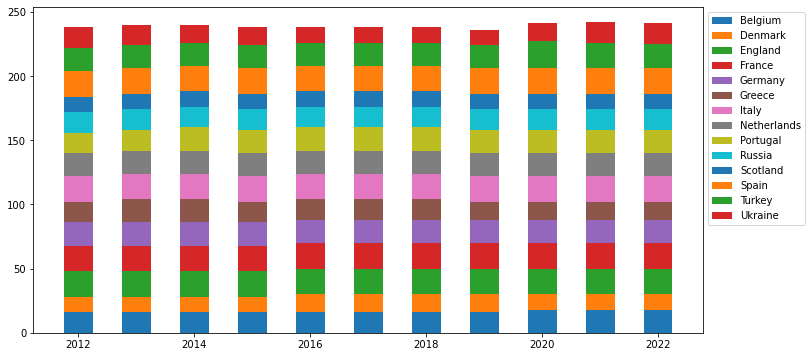

In [33]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

countries = pd_df['country'].unique()
seasons = pd_df['season'].unique()

width =0.5
bottom = np.zeros(len(seasons))

for country in countries:
    heights = pd_df[pd_df['country']==country]['NoClubs']
    p = ax.bar(seasons, heights, width, bottom=bottom, label=country)
    bottom += heights.values
    #print(bottom)
    
ax.legend(loc=0, bbox_to_anchor=(1.0,1.0))

plt.show()

There are a total of 14 football leagues in the database. Note that over the whole period (2012-2022) the clubs participating in the domestic tournament varies from year to year. Now, let's count the **number of goals** per season and per game for each year and country. 

In [112]:
# Here I use a subquery to count the number of total goals in each domestic competition
query = '''
        SELECT DISTINCT competition_id, country_name AS country, name AS leagueName,
        (SELECT SUM(home_club_goals + away_club_goals)
         FROM Games
         WHERE Games.competition_id = Competitions.competition_id) AS totalGoals,
        (SELECT ROUND(SUM(home_club_goals + away_club_goals) / (SELECT SUM(home_club_goals + away_club_goals)
         FROM Games
         WHERE Games.competition_type = 'domestic_league'), 3)
         FROM Games
         WHERE Games.competition_id = Competitions.competition_id) AS goalsFraction
        FROM Competitions
        WHERE Competitions.type = 'domestic_league'
        ORDER BY totalGoals;
        '''

df = spark.sql(query)

In [113]:
df.show()

+--------------+-----------+--------------------+----------+------------+
|competition_id|    country|          leagueName|totalGoals|goalFraction|
+--------------+-----------+--------------------+----------+------------+
|          UKR1|    Ukraine|        premier-liga|      5049|       0.042|
|           DK1|    Denmark|         superligaen|      5216|       0.043|
|           GR1|     Greece|      super-league-1|      5933|       0.049|
|           SC1|   Scotland|scottish-premiership|      6164|       0.051|
|           RU1|     Russia|        premier-liga|      6595|       0.055|
|           PO1|   Portugal|  liga-portugal-bwin|      8033|       0.067|
|           BE1|    Belgium|  jupiler-pro-league|      8138|       0.068|
|           TR1|     Turkey|           super-lig|      9947|       0.083|
|            L1|    Germany|          bundesliga|     10114|       0.084|
|           NL1|Netherlands|          eredivisie|     10137|       0.084|
|           FR1|     France|          

In [274]:
# We can also query the number of clubs per season for each country
query = '''
        SELECT c.competition_id,
               c.country_name as country,
               c.name as leagueName,
               c2.season,
               c2.totalGames,
               c2.goals,
               ROUND(c2.goals / c2.totalGames, 3) AS goalsPerGame,
               ROUND(c2.goals / c3.goals, 3) AS goalsFraction
        FROM Competitions AS c
        LEFT JOIN (SELECT competition_id,
            season,
            SUM(home_club_goals + away_club_goals) AS goals,
            COUNT(*) AS totalGames
            FROM Games as g
            WHERE g.competition_type = 'domestic_league'
            GROUP BY g.competition_id, g.season) AS c2
        on c.competition_id = c2.competition_id
        LEFT JOIN (SELECT season,
            SUM(home_club_goals + away_club_goals) AS goals
            FROM Games as g
            WHERE g.competition_type = 'domestic_league'
            GROUP BY g.season) AS c3
        on c2.season = c3.season 
        WHERE c.type = 'domestic_league'
        ORDER BY season, country
        '''

df = spark.sql(query)

In [275]:
df.show()

+--------------+-----------+--------------------+------+----------+-----+------------+-------------+
|competition_id|    country|          leagueName|season|totalGames|goals|goalsPerGame|goalsFraction|
+--------------+-----------+--------------------+------+----------+-----+------------+-------------+
|           BE1|    Belgium|  jupiler-pro-league|  2012|       240|  703|       2.929|        0.063|
|           DK1|    Denmark|         superligaen|  2012|       197|  558|       2.832|         0.05|
|           GB1|    England|      premier-league|  2012|       380| 1063|       2.797|        0.096|
|           FR1|     France|             ligue-1|  2012|       380|  967|       2.545|        0.087|
|            L1|    Germany|          bundesliga|  2012|       306|  898|       2.935|        0.081|
|           GR1|     Greece|      super-league-1|  2012|       240|  512|       2.133|        0.046|
|           IT1|      Italy|             serie-a|  2012|       380| 1003|       2.639|     

In [16]:
pd_df = df.toPandas()
pd_df.head()

,country,leagueName,season,totalGames,goals,goalsPerGame,goalsFraction
0,Belgium,jupiler-pro-league,2012,240,703,2.929,0.063
1,Denmark,superligaen,2012,197,558,2.832,0.050
2,England,premier-league,2012,380,1063,2.797,0.096
3,France,ligue-1,2012,380,967,2.545,0.087
4,Germany,bundesliga,2012,306,898,2.935,0.081


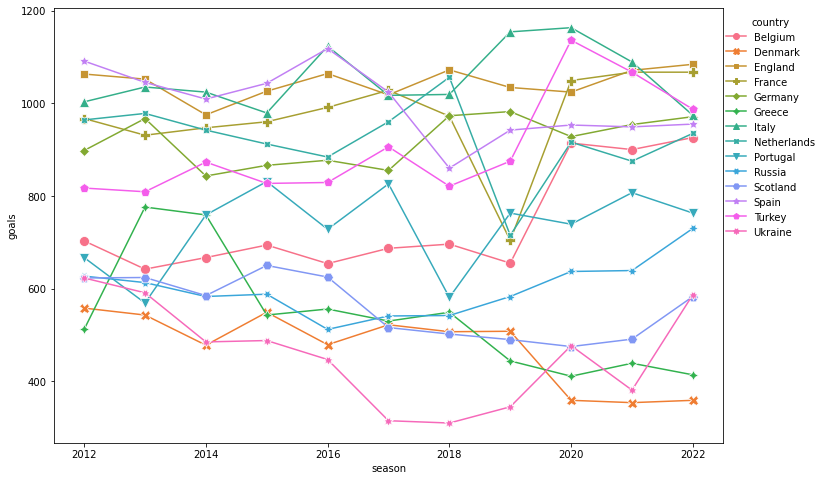

In [46]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

markers = ['o', 'v', '^', '<', '>', 's', 'p', 'P', '*', '+', 'x', 'X', 'd', 'D']
g= sns.lineplot(data=pd_df, x='season', y='goals', hue='country', style='country', markers=True, 
             dashes=False, markersize=10, ax=ax)

sns.move_legend(g, "upper right", bbox_to_anchor=(1.15, 1), ncol=1, frameon=False)

We can observe that the total number of goals scored each season varies greatly from year to year. Premier league seems to be the most consistent in this regard. We now want to explore competitivity of the league which can be measured using the **difference in points from first to last** and the number of **different champions** over the whole period.

These questions are more difficult since there is no explicit information about the number of points at the end of the season. The first team in the table and champion of the tournament has the largest number of points while the last team has the least number of points at the final matchday.

In [12]:
club_games.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- club_id: integer (nullable = true)
 |-- own_goals: integer (nullable = true)
 |-- own_position: integer (nullable = true)
 |-- own_manager_name: string (nullable = true)
 |-- opponent_id: integer (nullable = true)
 |-- opponent_goals: integer (nullable = true)
 |-- opponent_position: integer (nullable = true)
 |-- opponent_manager_name: string (nullable = true)
 |-- hosting: string (nullable = true)
 |-- is_win: integer (nullable = true)



In [203]:
# This query categorizes each match as Win, loss or draw
# It also assigns points according to the match result
query = '''
        SELECT Cb.game_id,
               Cb.club_id,
               G.competition_id,
               G.season as season,
               (CASE WHEN own_goals > opponent_goals THEN 'Win'
                     WHEN own_goals < opponent_goals THEN 'Loss'
                     ELSE 'Draw' END) as result,
               (CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END) as points
        FROM Club_games as Cb
        LEFT JOIN Games as G
        ON Cb.game_id = G.game_id
        WHERE G.competition_type = 'domestic_league'
        LIMIT 10;
        '''

df = spark.sql(query)

In [204]:
df.show()

+-------+-------+--------------+------+------+------+
|game_id|club_id|competition_id|season|result|points|
+-------+-------+--------------+------+------+------+
|2222539|     39|            L1|  2012|  Draw|     1|
|2222539|     60|            L1|  2012|  Draw|     1|
|2222541|      4|            L1|  2012|   Win|     3|
|2222541|     41|            L1|  2012|  Loss|     0|
|2222542|     15|            L1|  2012|  Loss|     0|
|2222542|     24|            L1|  2012|   Win|     3|
|2222595|   4128|           RU1|  2012|  Loss|     0|
|2222595|   2700|           RU1|  2012|   Win|     3|
|2222636|   2696|           RU1|  2012|   Win|     3|
|2222636|   1083|           RU1|  2012|  Loss|     0|
+-------+-------+--------------+------+------+------+



In [34]:
query = '''
        WITH S AS (
        SELECT G.competition_id AS competition_id,
               Cb.club_id AS first_id,
               G.season AS season,
               SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END) AS points,
               MAX(SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END)) OVER(PARTITION BY competition_id, season) AS max_points,
               MIN(SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END)) OVER(PARTITION BY competition_id, season) AS min_points,
               MAX(SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END)) OVER(PARTITION BY competition_id, season) - MIN(SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END)) OVER(PARTITION BY competition_id, season) AS point_diff
        FROM Club_games as Cb
        LEFT JOIN Games as G
            ON Cb.game_id = G.game_id
        WHERE G.competition_type = 'domestic_league'
        GROUP BY G.competition_id, Cb.club_id, G.season
        ORDER BY season)
        
        SELECT S.competition_id,
               C.country_name as country,
               C.name as leagueName,
               S.season,
               first_id,
               point_diff
        FROM S
        LEFT JOIN Competitions as C
            ON S.competition_id = C.competition_id
        WHERE S.points = max_points
        ORDER BY S.season, S.competition_id;
        '''

df = spark.sql(query)

In [35]:
df.show()

+--------------+-----------+--------------------+------+--------+----------+
|competition_id|    country|          leagueName|season|first_id|point_diff|
+--------------+-----------+--------------------+------+--------+----------+
|           BE1|    Belgium|  jupiler-pro-league|  2012|      58|        53|
|           DK1|    Denmark|         superligaen|  2012|     190|        34|
|           ES1|      Spain|              laliga|  2012|     131|        66|
|           FR1|     France|             ligue-1|  2012|     583|        54|
|           GB1|    England|      premier-league|  2012|     985|        64|
|           GR1|     Greece|      super-league-1|  2012|     683|        57|
|           IT1|      Italy|             serie-a|  2012|     506|        65|
|            L1|    Germany|          bundesliga|  2012|      27|        70|
|           NL1|Netherlands|          eredivisie|  2012|     610|        53|
|           PO1|   Portugal|  liga-portugal-bwin|  2012|     720|        55|

In [221]:
pd_df = df.toPandas()

In [222]:
pd_df[pd_df['country']=='Germany']

,country,leagueName,season,point_diff
4,Germany,bundesliga,2012,70
18,Germany,bundesliga,2013,65
32,Germany,bundesliga,2014,48
46,Germany,bundesliga,2015,63
60,Germany,bundesliga,2016,57
74,Germany,bundesliga,2017,62
88,Germany,bundesliga,2018,59
102,Germany,bundesliga,2019,62
116,Germany,bundesliga,2020,62
130,Germany,bundesliga,2021,59



It's time to analyze international competitions. In this case I will be only focusing on UEFA Champions league and UEFA Europa League.The questions we want to answer are: For each, country what is the number of victories at international competitions for each season? and what is the number of clubs playing international competitions each season?.

In [38]:
# First, let's investigate the different rounds at international competitions
query = '''
        SELECT DISTINCT round
        FROM Games as G
        WHERE (G.competition_id = 'CL' OR G.competition_id = 'EL');
        '''

df = spark.sql(query)

In [40]:
df.show(n=32)

+--------------------+
|               round|
+--------------------+
|               Final|
|             Group H|
| Semi-Finals 1st Leg|
|             group L|
|             group I|
|     last 16 1st leg|
|Qualifying Round ...|
|             Group A|
|     last 16 2nd leg|
|             Group E|
| Semi-Finals 2nd Leg|
|         Round of 16|
|      Quarter-Finals|
|intermediate stag...|
|Quarter-Finals 2n...|
|             group K|
|intermediate stag...|
|Qualifying Round ...|
|Second Round 2nd leg|
|             Group D|
|             Group G|
|             Group F|
|Quarter-Finals 1s...|
|             Group B|
|             group J|
|Second Round 1st leg|
|             Group C|
|         Semi-Finals|
+--------------------+



In [105]:
query = '''
        SELECT DISTINCT round
        FROM Games as G
        WHERE (G.competition_id = 'CL' OR G.competition_id = 'EL') AND (LOWER(G.round) NOT LIKE 'group%')
        AND (LOWER(G.round) NOT LIKE 'qualifying%')
        AND (LOWER(G.round) NOT LIKE 'intermediate%')
        AND (LOWER(G.round) NOT LIKE 'second round%');
        '''

df = spark.sql(query)

In [ ]:
df.show(n=32)

In the following query we filter for clubs in the 14 domestic leagues that are available in the Competitions table. 

In [64]:
query = '''
        WITH international AS (
        SELECT
            C.competition_id AS competition_id,
            C.country_name AS country,
            C.name AS domestic_league,
            G.season AS season,
            Cb.club_id,
            COUNT(*) AS total_matches,
            SUM(CASE WHEN LOWER(G.round) NOT LIKE 'group%' THEN 1
                       ELSE 0 END) AS playoffs_matches,
            SUM(CASE WHEN own_goals > opponent_goals THEN 1
                ELSE 0 END) AS total_wins
        FROM Club_games AS Cb
        LEFT JOIN Games as G
            ON Cb.game_id = G.game_id
        LEFT JOIN Clubs as Cl
            ON Cb.club_id = Cl.club_id
        LEFT JOIN Competitions as C
            ON CL.domestic_competition_id = C.competition_id
        WHERE (G.competition_id = 'CL'  OR G.competition_id = 'EL')
            AND (LOWER(G.round) NOT LIKE 'qualifying%')
            AND (LOWER(G.round) NOT LIKE 'intermediate%')
            AND (LOWER(G.round) NOT LIKE 'second round%')
            AND (Cl.domestic_competition_id IS NOT NULL)
        GROUP BY C.competition_id, C.country_name, C.name, G.season, Cb.club_id
        )
        SELECT
            competition_id,
            country,
            domestic_league,
            season,
            SUM(total_matches) AS total_matches,
            SUM(playoffs_matches) AS playoffs_matches,
            SUM(total_wins) AS total_wins
        FROM international
        GROUP BY competition_id, country, domestic_league, season
        ORDER BY season, country;
        '''

df = spark.sql(query)

In [65]:
df.show()

+--------------+-----------+--------------------+------+-------------+----------------+----------+
|competition_id|    country|     domestic_league|season|total_matches|playoffs_matches|total_wins|
+--------------+-----------+--------------------+------+-------------+----------------+----------+
|           BE1|    Belgium|  jupiler-pro-league|  2012|           18|               0|         5|
|           DK1|    Denmark|         superligaen|  2012|           12|               0|         2|
|           GB1|    England|      premier-league|  2012|           61|              19|        25|
|           FR1|     France|             ligue-1|  2012|           42|               6|        17|
|            L1|    Germany|          bundesliga|  2012|           60|              18|        32|
|           GR1|     Greece|      super-league-1|  2012|           12|               0|         4|
|           IT1|      Italy|             serie-a|  2012|           48|              12|        21|
|         

Finally I will create a single dataframe containing all the information calculated in the previous queries. To do this I will create temporal tables and join them to construct the final table.

In [12]:
query = '''
        CREATE TEMP VIEW Domestic_goals AS
        SELECT c.competition_id,
               c.country_name as country,
               c.name as leagueName,
               c2.season,
               c2.totalGames,
               c2.goals,
               ROUND(c2.goals / c2.totalGames, 3) AS goalsPerGame,
               ROUND(c2.goals / c3.goals, 3) AS goalsFraction
        FROM Competitions AS c
        LEFT JOIN (SELECT competition_id,
            season,
            SUM(home_club_goals + away_club_goals) AS goals,
            COUNT(*) AS totalGames
            FROM Games as g
            WHERE g.competition_type = 'domestic_league'
            GROUP BY g.competition_id, g.season) AS c2
        on c.competition_id = c2.competition_id
        LEFT JOIN (SELECT season,
            SUM(home_club_goals + away_club_goals) AS goals
            FROM Games as g
            WHERE g.competition_type = 'domestic_league'
            GROUP BY g.season) AS c3
        on c2.season = c3.season 
        WHERE c.type = 'domestic_league'
        ORDER BY season, country;
        '''

df = spark.sql(query)

In [13]:
query = '''
        CREATE TEMP VIEW Performance AS
        WITH S AS (
        SELECT G.competition_id AS competition_id,
               Cb.club_id AS first_id,
               G.season AS season,
               SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END) AS points,
               MAX(SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END)) OVER(PARTITION BY competition_id, season) AS max_points,
               MIN(SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END)) OVER(PARTITION BY competition_id, season) AS min_points,
               MAX(SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END)) OVER(PARTITION BY competition_id, season) - MIN(SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END)) OVER(PARTITION BY competition_id, season) AS point_diff
        FROM Club_games as Cb
        LEFT JOIN Games as G
            ON Cb.game_id = G.game_id
        WHERE G.competition_type = 'domestic_league'
        GROUP BY G.competition_id, Cb.club_id, G.season
        ORDER BY season)
        
        SELECT S.competition_id,
               C.country_name as country,
               C.name as leagueName,
               S.season,
               first_id,
               point_diff
        FROM S
        LEFT JOIN Competitions as C
            ON S.competition_id = C.competition_id
        WHERE S.points = max_points
        ORDER BY S.season, S.competition_id;
        '''

df = spark.sql(query)

In [23]:
query = '''
        DROP TABLE International;
        '''
df = spark.sql(query)

In [24]:
query = '''
        CREATE TEMP VIEW International AS 
        WITH international AS (
        SELECT
            C.competition_id AS competition_id,
            C.country_name AS country,
            C.name AS domestic_league,
            G.season AS season,
            Cb.club_id,
            COUNT(*) AS total_matches,
            SUM(CASE WHEN LOWER(G.round) NOT LIKE 'group%' THEN 1
                       ELSE 0 END) AS playoffs_matches,
            SUM(CASE WHEN own_goals > opponent_goals THEN 1
                ELSE 0 END) AS total_wins
        FROM Club_games AS Cb
        LEFT JOIN Games as G
            ON Cb.game_id = G.game_id
        LEFT JOIN Clubs as Cl
            ON Cb.club_id = Cl.club_id
        LEFT JOIN Competitions as C
            ON CL.domestic_competition_id = C.competition_id
        WHERE (G.competition_id = 'CL'  OR G.competition_id = 'EL')
            AND (LOWER(G.round) NOT LIKE 'qualifying%')
            AND (LOWER(G.round) NOT LIKE 'intermediate%')
            AND (LOWER(G.round) NOT LIKE 'second round%')
            AND (Cl.domestic_competition_id IS NOT NULL)
        GROUP BY C.competition_id, C.country_name, C.name, G.season, Cb.club_id
        )
        SELECT
            competition_id,
            country,
            domestic_league AS leagueName,
            season,
            SUM(total_matches) AS total_matches,
            SUM(playoffs_matches) AS playoffs_matches,
            SUM(total_wins) AS total_wins
        FROM international
        GROUP BY competition_id, country, domestic_league, season
        ORDER BY season, country;
        '''

df = spark.sql(query)

In [25]:
spark.catalog.listTables()

[Table(name='Appearances', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Club_games', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Clubs', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Competitions', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Domestic_goals', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Events', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Games', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='International', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='Performance', catalog=None, namespace=[], description=None, tableType='TEMPORAR

In [30]:
query = '''
        SELECT
            P.competition_id,
            P.country,
            P.leagueName,
            P.season,
            P.first_id,
            P.point_diff,
            D.totalGames,
            D.goals,
            D.goalsPerGame,
            I.total_matches,
            I.playoffs_matches,
            I.total_wins
        FROM Performance AS P
        LEFT JOIN Domestic_goals AS D
            ON P.competition_id = D.competition_id AND P.season = D.season
        LEFT JOIN International AS I
            ON P.competition_id = I.competition_id AND P.season = I.season
        ORDER BY season, country;
        '''

df = spark.sql(query)

In [31]:
df.show(10)

+--------------+-----------+------------------+------+--------+----------+----------+-----+------------+-------------+----------------+----------+
|competition_id|    country|        leagueName|season|first_id|point_diff|totalGames|goals|goalsPerGame|total_matches|playoffs_matches|total_wins|
+--------------+-----------+------------------+------+--------+----------+----------+-----+------------+-------------+----------------+----------+
|           BE1|    Belgium|jupiler-pro-league|  2012|      58|        53|       240|  703|       2.929|           18|               0|         5|
|           DK1|    Denmark|       superligaen|  2012|     190|        34|       197|  558|       2.832|           12|               0|         2|
|           GB1|    England|    premier-league|  2012|     985|        64|       380| 1063|       2.797|           61|              19|        25|
|           FR1|     France|           ligue-1|  2012|     583|        54|       380|  967|       2.545|           42|

In [32]:
# Convert to pandas
final_df = df.toPandas()

In [33]:
final_df.head()

,competition_id,country,leagueName,season,first_id,point_diff,totalGames,goals,goalsPerGame,total_matches,playoffs_matches,total_wins
0,BE1,Belgium,jupiler-pro-league,2012,58,53,240,703,2.929,18.0,0.0,5.0
1,DK1,Denmark,superligaen,2012,190,34,197,558,2.832,12.0,0.0,2.0
2,GB1,England,premier-league,2012,985,64,380,1063,2.797,61.0,19.0,25.0
3,FR1,France,ligue-1,2012,583,54,380,967,2.545,42.0,6.0,17.0
4,L1,Germany,bundesliga,2012,27,70,306,898,2.935,60.0,18.0,32.0


In [34]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competition_id    160 non-null    object 
 1   country           160 non-null    object 
 2   leagueName        160 non-null    object 
 3   season            160 non-null    int32  
 4   first_id          160 non-null    int32  
 5   point_diff        160 non-null    int64  
 6   totalGames        160 non-null    int64  
 7   goals             160 non-null    int64  
 8   goalsPerGame      160 non-null    float64
 9   total_matches     159 non-null    float64
 10  playoffs_matches  159 non-null    float64
 11  total_wins        159 non-null    float64
dtypes: float64(4), int32(2), int64(3), object(3)
memory usage: 13.9+ KB


Note that Russia has no information for the 2022 internation competition since it was banned due to **Russo-Ukrainian War**.

In [35]:
final_df[final_df['playoffs_matches'].isna()]

,competition_id,country,leagueName,season,first_id,point_diff,totalGames,goals,goalsPerGame,total_matches,playoffs_matches,total_wins
155,RU1,Russia,premier-liga,2022,964,57,240,730,3.042,NaN,NaN,NaN


In [36]:
# Remove duplicate that refer to seasons with a tie in points at the end of the tournament
final_df = final_df.drop_duplicates(subset=['competition_id', 'season'])

In [38]:
final_df.reset_index(inplace=True, drop=True)

In [40]:
final_df.head()

,competition_id,country,leagueName,season,first_id,point_diff,totalGames,goals,goalsPerGame,total_matches,playoffs_matches,total_wins
0,BE1,Belgium,jupiler-pro-league,2012,58,53,240,703,2.929,18.0,0.0,5.0
1,DK1,Denmark,superligaen,2012,190,34,197,558,2.832,12.0,0.0,2.0
2,GB1,England,premier-league,2012,985,64,380,1063,2.797,61.0,19.0,25.0
3,FR1,France,ligue-1,2012,583,54,380,967,2.545,42.0,6.0,17.0
4,L1,Germany,bundesliga,2012,27,70,306,898,2.935,60.0,18.0,32.0


In [42]:
# Save dataframe into csv file
final_df.to_csv("football_league_performance.csv", index=False)

## Conclusions

## Tests

In [ ]:
query = '''
        WITH international AS ( 
        SELECT
            C.country_name AS country,
            C.name AS domestic_league,
            G.season AS season,
            G.competition_id,
            --Cb.club_id,
            COUNT(*) AS total_matches,
            SUM(CASE WHEN (LOWER(G.round) NOT LIKE 'group%' AND
                           LOWER(G.round) NOT LIKE 'qualifying%' AND
                           LOWER(G.round) NOT LIKE 'intermediate%' AND
                           LOWER(G.round) NOT LIKE 'second round%') THEN 1
                       ELSE 0 END) AS playoffs_matches,
            SUM(CASE WHEN own_goals > opponent_goals THEN 1
                ELSE 0 END) AS total_wins
        FROM Club_games AS Cb
        LEFT JOIN Games as G
            ON Cb.game_id = G.game_id
        LEFT JOIN Clubs as Cl
            ON Cb.club_id = Cl.club_id
        LEFT JOIN Competitions as C
            ON CL.domestic_competition_id = C.competition_id
        WHERE G.competition_id = 'CL' OR G.competition_id = 'EL'
        GROUP BY C.country_name, C.name, G.season, G.competition_id, Cb.club_id)
        
        SELECT
        country,
        domestic_league,
        season,
        SUM(total_matches),
        SUM(playoffs_matches),
        SUM(total_wins)
        FROM international
        GROUP BY country, domestic_league, season
        ORDER BY season, country;
        '''

df = 

In [195]:
query = '''
        SELECT
        competition_id,
        season,
        round,
        date,
        home_club_name,
        away_club_name
        FROM Games as G
        WHERE (G.competition_id = 'CL' OR G.competition_id = 'EL') 
            AND (home_club_id = 2481 OR home_club_id = 2481) and season = 2022;
        '''

df = spark.sql(query)

In [196]:
df.show()

+--------------+------+-------+----------+--------------+-----------------+
|competition_id|season|  round|      date|home_club_name|   away_club_name|
+--------------+------+-------+----------+--------------+-----------------+
|            EL|  2022|Group E|2022-10-06|          null|    Real Sociedad|
|            EL|  2022|Group E|2022-09-15|          null|Manchester United|
|            EL|  2022|Group E|2022-11-03|          null|             null|
+--------------+------+-------+----------+--------------+-----------------+



In [159]:
query = '''
        SELECT Cb.game_id,
               round,
               own_goals,
               opponent_goals
        FROM Club_games as Cb
        LEFT JOIN Games as G
        ON Cb.game_id = G.game_id
        WHERE Cb.club_id = 938
        '''

df = spark.sql(query)

In [160]:
df.show()

+-------+--------------------+---------+--------------+
|game_id|               round|own_goals|opponent_goals|
+-------+--------------------+---------+--------------+
|2367346|             Group G|        0|             1|
|2367220|             Group G|        1|             0|
|2583620|Second Round 2nd leg|        2|             1|
|2605684|   3rd round 1st leg|        0|             0|
|2345067|Second Round 1st leg|        2|             0|
|2360973|Qualifying Round ...|        3|             0|
|2367302|             Group G|        0|             2|
|2618170|   4th round 2nd leg|        3|             3|
|2351355|   3rd round 2nd leg|        1|             0|
|3232462|   3rd round 1st leg|        2|             3|
|3232470|   3rd round 2nd leg|        1|             2|
|2345090|Second Round 2nd leg|        3|             1|
|2367265|             Group G|        0|             3|
|2604789|   3rd round 2nd leg|        2|             2|
|2614736|   4th round 1st leg|        1|        

In [12]:
query = '''
        WITH S AS (SELECT G.competition_id,
               Cb.club_id,
               G.season as season,
               SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END) as points
        FROM Club_games as Cb
        LEFT JOIN Games as G
        ON Cb.game_id = G.game_id
        WHERE G.competition_type = 'domestic_league'
        GROUP BY G.competition_id, Cb.club_id, G.season
        ORDER BY season)
        SELECT T.competition_id,
               T.season,
               T.club_id,
               T.points,
               T.max_points
        FROM(SELECT S.competition_id,
               S.season, 
               S.club_id,
               S.points,
               S2.max_points
        FROM S
        LEFT JOIN (SELECT competition_id,
                          season,
                          MAX(points) as max_points
                   FROM S 
                   GROUP BY S.competition_id, S.season) AS S2
        ON S.competition_id = S2.competition_id AND S.season = S2.season 
        ORDER BY season) as T
        WHERE T.points = T.max_points
        ORDER BY season, competition_id;
        '''

df = spark.sql(query)

In [13]:
df.show()

+--------------+------+-------+------+----------+
|competition_id|season|club_id|points|max_points|
+--------------+------+-------+------+----------+
|           BE1|  2012|     58|    67|        67|
|           DK1|  2012|    190|    65|        65|
|           ES1|  2012|    131|   100|       100|
|           FR1|  2012|    583|    83|        83|
|           GB1|  2012|    985|    89|        89|
|           GR1|  2012|    683|    77|        77|
|           IT1|  2012|    506|    87|        87|
|            L1|  2012|     27|    91|        91|
|           NL1|  2012|    610|    76|        76|
|           PO1|  2012|    720|    78|        78|
|           RU1|  2012|   2410|    64|        64|
|           SC1|  2012|    371|    79|        79|
|           TR1|  2012|    141|    71|        71|
|          UKR1|  2012|    660|    79|        79|
|           BE1|  2013|   3057|    67|        67|
|           DK1|  2013|   1053|    62|        62|
|           ES1|  2013|     13|    90|        90|


In [260]:
pd_df = df.toPandas()

In [273]:
pd_df[pd_df['season']==2022].groupby('competition_id').count()

,season,club_id,points,max_points
competition_id,,,,
BE1,2,2,2,2
DK1,1,1,1,1
ES1,1,1,1,1
FR1,1,1,1,1
GB1,1,1,1,1
GR1,1,1,1,1
IT1,1,1,1,1
L1,2,2,2,2
NL1,1,1,1,1


In [23]:
query = '''
        WITH S AS (SELECT G.competition_id AS competition,
               Cb.club_id AS first,
               G.season AS season,
               SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END) AS points,
               MAX(SUM(CASE WHEN own_goals > opponent_goals THEN 3
                     WHEN own_goals < opponent_goals THEN 0
                     ELSE 1 END)) OVER(PARTITION BY competition_id, season) AS max_points
        FROM Club_games as Cb
        LEFT JOIN Games as G
        ON Cb.game_id = G.game_id
        WHERE G.competition_type = 'domestic_league'
        GROUP BY G.competition_id, Cb.club_id, G.season
        ORDER BY season)
        
        SELECT competition,
               season,
               first,
               points,
               max_points
        FROM S
        WHERE points = max_points
        ORDER BY season, competition;
        '''

df = spark.sql(query)

In [24]:
df.show()

+-----------+------+-----+------+----------+
|competition|season|first|points|max_points|
+-----------+------+-----+------+----------+
|        BE1|  2012|   58|    67|        67|
|        DK1|  2012|  190|    65|        65|
|        ES1|  2012|  131|   100|       100|
|        FR1|  2012|  583|    83|        83|
|        GB1|  2012|  985|    89|        89|
|        GR1|  2012|  683|    77|        77|
|        IT1|  2012|  506|    87|        87|
|         L1|  2012|   27|    91|        91|
|        NL1|  2012|  610|    76|        76|
|        PO1|  2012|  720|    78|        78|
|        RU1|  2012| 2410|    64|        64|
|        SC1|  2012|  371|    79|        79|
|        TR1|  2012|  141|    71|        71|
|       UKR1|  2012|  660|    79|        79|
|        BE1|  2013| 3057|    67|        67|
|        DK1|  2013| 1053|    62|        62|
|        ES1|  2013|   13|    90|        90|
|        FR1|  2013|  583|    89|        89|
|        GB1|  2013|  281|    86|        86|
|        G

In [88]:
# First let's obtain the number of stages for each country
query = '''
        SELECT competition_id,
        season,
        MAX(CAST(SPLIT(round, '\\\\.')[0] AS INT)) AS round
        FROM Games
        WHERE Games.competition_type = 'domestic_league'
        GROUP BY competition_id, season;
        '''

df = spark.sql(query)

In [89]:
df.show()

+--------------+------+-----+
|competition_id|season|round|
+--------------+------+-----+
|           NL1|  2019|   26|
|           SC1|  2020|   33|
|           GR1|  2018|   30|
|           GR1|  2022|   26|
|           IT1|  2022|   38|
|           IT1|  2012|   38|
|           TR1|  2017|   34|
|           BE1|  2017|   30|
|           GR1|  2019|   26|
|           ES1|  2014|   38|
|           RU1|  2014|   30|
|           BE1|  2014|   30|
|           NL1|  2022|   34|
|           GB1|  2012|   38|
|           ES1|  2012|   38|
|           RU1|  2018|   30|
|           IT1|  2020|   38|
|           TR1|  2012|   34|
|           IT1|  2013|   38|
|           TR1|  2016|   34|
+--------------+------+-----+
only showing top 20 rows



In [157]:
# First let's obtain the number of stages for each country
query = '''
        SELECT C.country_name AS country,
               C.name AS leagueName,
               G.season AS season,
               G.game_id,
               G.home_club_position,
               G.away_club_position
        FROM Competitions as C
        LEFT JOIN Games as G
        ON C.competition_id = G.competition_id
        LEFT JOIN (SELECT competition_id,
                   season,
                   MAX(CAST(SPLIT(round, '\\\\.')[0] AS INT)) as last_round
                   FROM Games
                   WHERE Games.competition_type = 'domestic_league'
                   GROUP BY competition_id, season) as S
        ON C.competition_id = S.competition_id AND G.season = S.season
        WHERE CAST(SPLIT(G.round, '\\\\.')[0] AS INT) = S.last_round AND C.type='domestic_league';
        '''

df = spark.sql(query)

In [150]:
df.show()

+-----------+--------------------+------+-------+-----+----------+
|    country|          leagueName|season|game_id|round|last_round|
+-----------+--------------------+------+-------+-----+----------+
|Netherlands|          eredivisie|  2012|2250470|   34|        34|
|   Portugal|  liga-portugal-bwin|  2015|2613701|   34|        34|
|    Belgium|  jupiler-pro-league|  2015|2668509|   30|        30|
|    Ukraine|        premier-liga|  2016|2854408|   32|        32|
|    Denmark|         superligaen|  2018|3063780|   26|        26|
|      Spain|              laliga|  2019|3208629|   38|        38|
|    England|      premier-league|  2019|3219102|   38|        38|
|    Ukraine|        premier-liga|  2022|4070623|   30|        30|
|   Scotland|scottish-premiership|  2013|2452090|   38|        38|
|     Greece|      super-league-1|  2017|2891647|   30|        30|
|      Italy|             serie-a|  2017|2897541|   38|        38|
|     Greece|      super-league-1|  2019|3309820|   26|       

In [158]:
pd_df = df.toPandas()

In [176]:
pd_df[((pd_df['home_club_position']==1) | (pd_df['away_club_position']==1)) & (pd_df['season']==2018)]

,country,leagueName,season,game_id,home_club_position,away_club_position
42,Denmark,superligaen,2018,3063780,1,13
150,Russia,premier-liga,2018,3183732,1,16
176,Scotland,scottish-premiership,2018,3080391,1,9
254,Netherlands,eredivisie,2018,3141202,17,1
328,Germany,bundesliga,2018,3058720,1,7
332,Italy,serie-a,2018,3081405,9,1
405,Turkey,super-lig,2018,3070006,12,1
482,Greece,super-league-1,2018,3159963,14,1
647,Belgium,jupiler-pro-league,2018,3140035,11,1
791,England,premier-league,2018,3050561,17,1


In [148]:
games.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- competition_id: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- round: string (nullable = true)
 |-- date: date (nullable = true)
 |-- home_club_id: integer (nullable = true)
 |-- away_club_id: integer (nullable = true)
 |-- home_club_goals: integer (nullable = true)
 |-- away_club_goals: integer (nullable = true)
 |-- home_club_position: integer (nullable = true)
 |-- away_club_position: integer (nullable = true)
 |-- home_club_manager_name: string (nullable = true)
 |-- away_club_manager_name: string (nullable = true)
 |-- stadium: string (nullable = true)
 |-- attendance: integer (nullable = true)
 |-- referee: string (nullable = true)
 |-- url: string (nullable = true)
 |-- home_club_name: string (nullable = true)
 |-- away_club_name: string (nullable = true)
 |-- aggregate: timestamp (nullable = true)
 |-- competition_type: string (nullable = true)



In [68]:
from pyspark.sql.functions import isnan, when, count, col

# To count the number of missing values let's define a function

def show_missing_values(name, dataframe):
    print(name.capitalize())
    dataframe.select([count(when(isnan(c), c)).alias(c) for c,t  in dataframe.dtypes if (t != 'date' and t != 'timestamp')]).show()

In [69]:
for name, df in zip(names, dataframes):
    show_missing_values(name, df)

Competitions
+--------------+----------------+----+--------+----+----------+------------+--------------------+-------------+---+
|competition_id|competition_code|name|sub_type|type|country_id|country_name|domestic_league_code|confederation|url|
+--------------+----------------+----+--------+----+----------+------------+--------------------+-------------+---+
|             0|               0|   0|       0|   0|         0|           0|                   0|            0|  0|
+--------------+----------------+----+--------+----+----------+------------+--------------------+-------------+---+

Clubs
+-------+---------+----+-----------------------+------------------+----------+-----------+-----------------+---------------------+---------------------+------------+-------------+-------------------+----------+-----------+---+
|club_id|club_code|name|domestic_competition_id|total_market_value|squad_size|average_age|foreigners_number|foreigners_percentage|national_team_players|stadium_name|stadium_

+-------+-------+---------+------------+----------------+-----------+--------------+-----------------+---------------------+-------+------+
|game_id|club_id|own_goals|own_position|own_manager_name|opponent_id|opponent_goals|opponent_position|opponent_manager_name|hosting|is_win|
+-------+-------+---------+------------+----------------+-----------+--------------+-----------------+---------------------+-------+------+
|      0|      0|        0|           0|               0|          0|             0|                0|                    0|      0|     0|
+-------+-------+---------+------------+----------------+-----------+--------------+-----------------+---------------------+-------+------+

Games


+-------+--------------+------+-----+------------+------------+---------------+---------------+------------------+------------------+----------------------+----------------------+-------+----------+-------+---+--------------+--------------+----------------+
|game_id|competition_id|season|round|home_club_id|away_club_id|home_club_goals|away_club_goals|home_club_position|away_club_position|home_club_manager_name|away_club_manager_name|stadium|attendance|referee|url|home_club_name|away_club_name|competition_type|
+-------+--------------+------+-----+------------+------------+---------------+---------------+------------------+------------------+----------------------+----------------------+-------+----------+-------+---+--------------+--------------+----------------+
|      0|             0|     0|    0|           0|           0|              0|              0|                 0|                 0|                     0|                     0|      0|         0|      0|  0|             0| 

+---------+-----------+-------------------+---+---------------+-----------------------------------+
|player_id|last_season|market_value_in_eur|  n|current_club_id|player_club_domestic_competition_id|
+---------+-----------+-------------------+---+---------------+-----------------------------------+
|        0|          0|                  0|  0|              0|                                  0|
+---------+-----------+-------------------+---+---------------+-----------------------------------+

Appearances


+-------------+-------+---------+--------------+----------------------+-----------+--------------+------------+---------+-----+-------+--------------+
|appearance_id|game_id|player_id|player_club_id|player_current_club_id|player_name|competition_id|yellow_cards|red_cards|goals|assists|minutes_played|
+-------------+-------+---------+--------------+----------------------+-----------+--------------+------------+---------+-----+-------+--------------+
|            0|      0|        0|             0|                     0|          0|             0|           0|        0|    0|      0|             0|
+-------------+-------+---------+--------------+----------------------+-----------+--------------+------------+---------+-----+-------+--------------+

Players


+---------+----------+---------+----+-----------+---------------+-----------+----------------+-------------+----------------------+------------+--------+----+------------+-------------------+---------------------------+----------+---------+---+------------------------------------+-----------------+
|player_id|first_name|last_name|name|last_season|current_club_id|player_code|country_of_birth|city_of_birth|country_of_citizenship|sub_position|position|foot|height_in_cm|market_value_in_eur|highest_market_value_in_eur|agent_name|image_url|url|current_club_domestic_competition_id|current_club_name|
+---------+----------+---------+----+-----------+---------------+-----------+----------------+-------------+----------------------+------------+--------+----+------------+-------------------+---------------------------+----------+---------+---+------------------------------------+-----------------+
|        0|         0|        0|   0|          0|              0|          0|               0|      

+-------+------+----+-------+---------+-----------+------------+
|game_id|minute|type|club_id|player_id|description|player_in_id|
+-------+------+----+-------+---------+-----------+------------+
|      0|     0|   0|      0|        0|          0|           0|
+-------+------+----+-------+---------+-----------+------------+



In [45]:
print_statistical_summary(clubs)

+-------+------------------+-----------------+------------------+------------------+---------------------+
|summary|           club_id|       squad_size|       average_age| foreigners_number|foreigners_percentage|
+-------+------------------+-----------------+------------------+------------------+---------------------+
|  count|               411|              411|               373|               411|                  365|
|   mean| 4879.778588807786|24.51094890510949|25.691152815013417|10.914841849148418|    44.86410958904111|
| stddev|10896.048964698235| 8.89130854452641|1.4859022134296458| 6.629207263190824|    19.52414395948243|
|    min|                 3|                0|              21.0|                 0|                  2.4|
|    max|             83678|               41|              29.5|                27|                100.0|
+-------+------------------+-----------------+------------------+------------------+---------------------+

+-------+---------------------+-----

In [91]:
query = '''
        Select DISTINCT G.competition_id, C.name AS CompetitionName, C.country_name AS CountryName
        FROM Games AS G
        LEFT JOIN Competitions AS C
        ON G.competition_id = C.competition_id
        WHERE C.country_name = "Russia"
        '''

df = spark.sql(query)

In [113]:
df = df.toPandas()

In [114]:
df

,country_name,clubs_count
0,England,35
1,Spain,32
2,Denmark,19
3,France,34
4,Russia,31
5,Scotland,16
6,Portugal,32
7,Germany,28
8,Belgium,25
9,Ukraine,31


In [112]:
query = '''
        SELECT DISTINCT country_name,
        (SELECT COUNT(*)
         FROM Clubs
         WHERE Clubs.domestic_competition_id = Competitions.competition_id) AS clubs_count
        FROM Competitions
        WHERE Competitions.type = 'domestic_league'
        '''

df = spark.sql(query)

In [108]:
query = '''
        SELECT domestic_competition_id, COUNT(DISTINCT name)
        FROM clubs
        GROUP BY domestic_competition_id
        '''

spark.sql(query).show()

+-----------------------+--------------------+
|domestic_competition_id|count(DISTINCT name)|
+-----------------------+--------------------+
|                    IT1|                  37|
|                    BE1|                  25|
|                    GR1|                  26|
|                   UKR1|                  31|
|                    NL1|                  27|
|                    SC1|                  16|
|                    FR1|                  34|
|                    RU1|                  31|
|                    ES1|                  32|
|                    PO1|                  32|
|                    GB1|                  35|
|                    TR1|                  38|
|                     L1|                  28|
|                    DK1|                  19|
+-----------------------+--------------------+



In [85]:
df.head()

,competition_id,CompetitionName,CountryName
0,CGB,efl-cup,England
1,GBCS,community-shield,England
2,GB1,premier-league,England
3,FAC,fa-cup,England
